# JAX-CFD demo

This initial demonstration shows how to use JAX-CFD to simulate decaying turbulence in 2D.

In [1]:
import jax
import jax.numpy as jnp
import jax_cfd.base as cfd
import numpy as np
import seaborn
import xarray

In [2]:
size = 256
density = 1.
viscosity = 1e-3
seed = 0
inner_steps = 25
outer_steps = 2000

max_velocity = 2.0
cfl_safety_factor = 0.5

# Define the physical dimensions of the simulation.
grid = cfd.grids.Grid((size, size), domain=((0, 2 * jnp.pi), (0, 2 * jnp.pi)))

# Construct a random initial velocity. The `filtered_velocity_field` function
# ensures that the initial velocity is divergence free and it filters out
# high frequency fluctuations.
v0 = cfd.initial_conditions.filtered_velocity_field(
    jax.random.PRNGKey(seed), grid, max_velocity)

# Choose a time step.
dt = cfd.equations.stable_time_step(
    max_velocity, cfl_safety_factor, viscosity, grid)

# Define a step function and use it to compute a trajectory.
step_fn = cfd.funcutils.repeated(
    cfd.equations.semi_implicit_navier_stokes(
        density=density, viscosity=viscosity, dt=dt, grid=grid),
    steps=inner_steps)
rollout_fn = jax.jit(cfd.funcutils.trajectory(step_fn, outer_steps))
%time _, trajectory = jax.device_get(rollout_fn(v0))

No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


CPU times: user 2min 8s, sys: 2.33 s, total: 2min 11s
Wall time: 52.4 s


In [3]:
# JAX-CFD uses GridVariable objects for input/output. These objects contain:
#  - array data
#  - an "offset" that documents the position on the unit-cell where the data
#    values are located
#  - grid properties
#  - boundary conditions on the variable
with np.printoptions(edgeitems=1):
  for i, u in enumerate(trajectory):
    print(f'Component {i}: {u}')

Component 0: GridVariable(array=GridArray(data=array([[[-0.89350396, ..., -0.8515546 ],
        ...,
        [-0.90172863, ..., -0.86095315]],

       ...,

       [[ 0.05969305, ...,  0.04689904],
        ...,
        [ 0.05948671, ...,  0.04670579]]], dtype=float32), offset=(1.0, 0.5), grid=Grid(shape=(256, 256), step=(0.02454369260617026, 0.02454369260617026), domain=((0.0, 6.283185307179586), (0.0, 6.283185307179586)))), bc=HomogeneousBoundaryConditions(types=(('periodic', 'periodic'), ('periodic', 'periodic')), bc_values=((0.0, 0.0), (0.0, 0.0))))
Component 1: GridVariable(array=GridArray(data=array([[[0.14294599, ..., 0.1511707 ],
        ...,
        [0.17220268, ..., 0.18040821]],

       ...,

       [[0.1026273 , ..., 0.10283364],
        ...,
        [0.11526749, ..., 0.11549944]]], dtype=float32), offset=(0.5, 1.0), grid=Grid(shape=(256, 256), step=(0.02454369260617026, 0.02454369260617026), domain=((0.0, 6.283185307179586), (0.0, 6.283185307179586)))), bc=HomogeneousBounda

In [4]:
# load into xarray for visualization and analysis
ds = xarray.Dataset(
    {
        'u': (('time', 'x', 'y'), trajectory[0].data),
        'v': (('time', 'x', 'y'), trajectory[1].data),
    },
    coords={
        'x': grid.axes()[0],
        'y': grid.axes()[1],
        'time': dt * inner_steps * np.arange(outer_steps)
    }
)

/home/junyi/jax-cfd/jax_cfd/data/xarray_utils.py:196: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  result = xarray.apply_ufunc(
/home/junyi/jax-cfd/jax_cfd/data/xarray_utils.py:196: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  result = xarray.apply_ufunc(


(127,)


[]

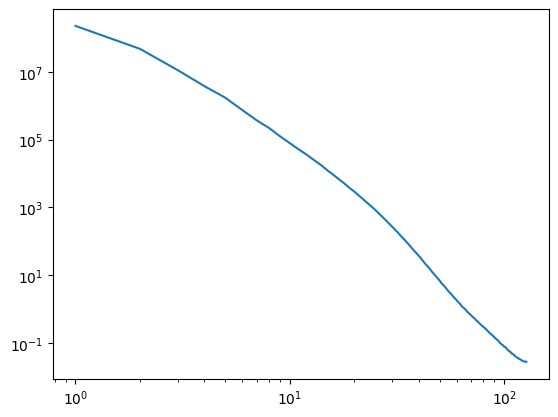

In [5]:
import jax_cfd.data as ans
Ek = ans.xarray_utils.isotropic_energy_spectrum(ds,('time'))
print(Ek.data.shape)
import matplotlib.pyplot as plt
plt.plot(np.arange(1,len(Ek.data)+1),Ek.data)
plt.loglog()

(2000, 256, 256)
(2000, 256, 256)
(2000, 256, 256)


[]

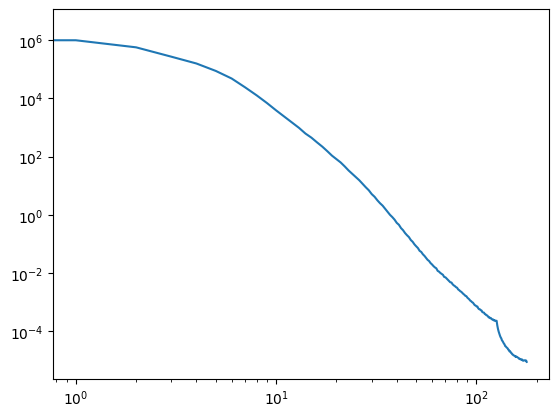

In [9]:

def azimuthalAverage(image, center=None):
    """
    Calculate the azimuthally averaged radial profile.

    image - The 2D image
    center - The [x,y] pixel coordinates used as the center. The default is 
             None, which then uses the center of the image (including 
             fracitonal pixels).
    
    """
    # Calculate the indices from the image
    y, x = np.indices(image.shape)

    if not center:
        center = np.array([(x.max()-x.min())/2.0, (x.max()-x.min())/2.0])

    r = np.hypot(x - center[0], y - center[1])

    # Get sorted radii
    ind = np.argsort(r.flat)
    r_sorted = r.flat[ind]
    i_sorted = image.flat[ind]

    # Get the integer part of the radii (bin size = 1)
    r_int = r_sorted.astype(int)

    # Find all pixels that fall within each radial bin.
    deltar = r_int[1:] - r_int[:-1]  # Assumes all radii represented
    rind = np.where(deltar)[0]       # location of changed radius
    nr = rind[1:] - rind[:-1]        # number of radius bin
    
    # Cumulative sum to figure out sums for each radius bin
    csim = np.cumsum(i_sorted, dtype=float)
    tbin = csim[rind[1:]] - csim[rind[:-1]]

    radial_prof = tbin / nr

    return radial_prof

u= ds['u'].values
v= ds['v'].values
print(u.shape)
u_mean = np.mean(u, axis = 0)
v_mean = np.mean(v, axis = 0)
true_u = u - u_mean
print(true_u.shape)
true_v = v - v_mean
tke = 0.5*(true_u**2 + true_v**2)

print(tke.shape)

def tke2spectrum(tke):
    sp = np.fft.fft2(tke)
    sp = np.fft.fftshift(sp)
    sp = np.real(sp*np.conjugate(sp))
    sp1D = azimuthalAverage(sp)
    return sp1D

spec = np.array([tke2spectrum(tke[i]) for i in range(tke.shape[0])])
x,s = np.mean(spec, axis = 0), np.std(spec, axis = 0)
x_idx = np.array(list(range(0,len(s))))
plt.plot(x_idx,s)
plt.loglog()


Reading files...localtime Thu Aug 31 18:14:49 2023
shape of data =  (2000, 2, 256, 256)
Reading files...localtime Thu Aug 31 18:14:49 2023 - END

Computing spectrum...  Thu Aug 31 18:14:49 2023
N = 256
amplsU.shape = (256, 256)
box sidex     = 256
box sidey     = 256
sphere radius = 183
centerbox     = 128
centerboy     = 128
129
Real      Kmax    =  129
Spherical Kmax    =  183
the KE  of the mean velocity discrete  =  1.3768817584122774e-16
the KE  of the mean velocity sphere    =  2.37688175848916e-16
the mean KE discrete  =  0.01146033126860857
the mean KE sphere    =  0.011460331785909687
Computing spectrum...  Thu Aug 31 18:14:49 2023 - END 



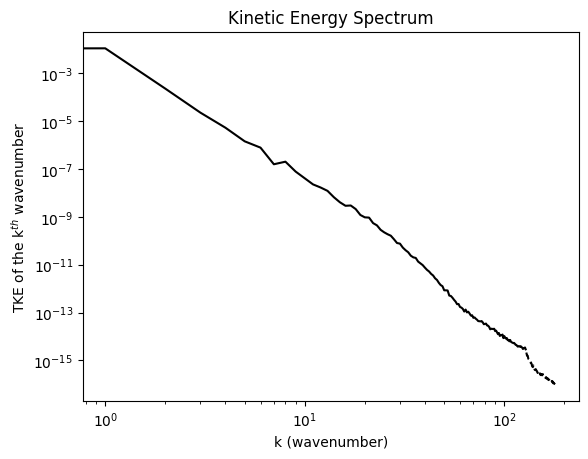

In [8]:
# python 3
u = ds['u'].values
v = ds['v'].values
# Script for the computation of 3D spectrum of the Total Kinetic Energy
# Adapted to the Taylor-Green vortex (TGV) problem.
# CREATED by FARSHAD NAVAH
# McGill University
# farshad.navah .a.t. mail.mcgill.ca
# 2018
# provided as is with no garantee.
# Please cite:
#    https://github.com/fanav/Energy_Spectrum
#    https://arxiv.org/abs/1809.03966

# -----------------------------------------------------------------
#  IMPORTS - ENVIRONMENT
# -----------------------------------------------------------------

import numpy as np
import matplotlib.pyplot as plt
import time
from math import sqrt

# -----------------------------------------------------------------
#  TGV QUANTS
# -----------------------------------------------------------------

# These quantities are to account for particular non-dimensionalizations of state variables.
# In general U0=1.
c  = sqrt(1.4);
Ma = 0.1;
U0 = 1.0; 

# -----------------------------------------------------------------
#  INPUT FILE PARAMS
# -----------------------------------------------------------------

# -----------------------------------------------------------------
#  OUTOUT FILE PARAMS
# -----------------------------------------------------------------

Figs_Path = "./"
Fig_file_name = "Ek_Spectrum"

# -----------------------------------------------------------------
#  READ FILES
# -----------------------------------------------------------------

localtime = time.asctime( time.localtime(time.time()) )
print ("\nReading files...localtime",localtime)

#load the ascii file
data = np.stack((u,v),axis=1)

print ("shape of data = ",data.shape)

localtime = time.asctime( time.localtime(time.time()) )
print ("Reading files...localtime",localtime, "- END\n")

# -----------------------------------------------------------------
#  COMPUTATIONS
# -----------------------------------------------------------------
localtime = time.asctime( time.localtime(time.time()) )
print ("Computing spectrum... ",localtime)

N = data.shape[-1]
print("N =",N)
eps = 1e-16 # to void log(0)

U = data[:,0].mean(axis=0)
V = data[:,1].mean(axis=0)
# U = data[:,3].reshape(N,N,N)/U0
# V = data[:,4].reshape(N,N,N)/U0
# W = data[:,5].reshape(N,N,N)/U0

amplsU = abs(np.fft.fftn(U)/U.size)
amplsV = abs(np.fft.fftn(V)/V.size)
print(f"amplsU.shape = {amplsU.shape}")
# amplsW = abs(np.fft.fftn(W)/W.size)

EK_U  = amplsU**2
EK_V  = amplsV**2 
# EK_W  = amplsW**2 

EK_U = np.fft.fftshift(EK_U)
EK_V = np.fft.fftshift(EK_V)
# EK_W = np.fft.fftshift(EK_W)

sign_sizex = np.shape(EK_U)[0]
sign_sizey = np.shape(EK_U)[1]
# sign_sizez = np.shape(EK_U)[2]

box_sidex = sign_sizex
box_sidey = sign_sizey
# box_sidez = sign_sizez

# box_radius = int(np.ceil((np.sqrt((box_sidex)**2+(box_sidey)**2+(box_sidez)**2))/2.)+1)
box_radius = int(np.ceil((np.sqrt((box_sidex)**2+(box_sidey)**2))/2.)+1)
centerx = int(box_sidex/2)
centery = int(box_sidey/2)
# centerz = int(box_sidez/2)

print ("box sidex     =",box_sidex) 
print ("box sidey     =",box_sidey) 
# print ("box sidez     =",box_sidez)
print ("sphere radius =",box_radius )
print ("centerbox     =",centerx)
print ("centerboy     =",centery)
# print ("centerboz     =",centerz,"\n" )
	            
EK_U_avsphr = np.zeros(box_radius,)+eps ## size of the radius
EK_V_avsphr = np.zeros(box_radius,)+eps ## size of the radius
# EK_W_avsphr = np.zeros(box_radius,)+eps ## size of the radius

# for i in range(box_sidex):
# 	for j in range(box_sidey):
# 		for k in range(box_sidez):            
# 			wn =  int(np.round(np.sqrt((i-centerx)**2+(j-centery)**2+(k-centerz)**2)))
# 			EK_U_avsphr[wn] = EK_U_avsphr [wn] + EK_U [i,j,k]
# 			EK_V_avsphr[wn] = EK_V_avsphr [wn] + EK_V [i,j,k]    
# 			EK_W_avsphr[wn] = EK_W_avsphr [wn] + EK_W [i,j,k]        
for i in range(box_sidex):
	for j in range(box_sidey):          
		wn =  int(np.round(np.sqrt((i-centerx)**2+(j-centery)**2)))
		EK_U_avsphr[wn] = EK_U_avsphr [wn] + EK_U [i,j]
		EK_V_avsphr[wn] = EK_V_avsphr [wn] + EK_V [i,j]     
EK_avsphr = 0.5*(EK_U_avsphr + EK_V_avsphr)
	                      
fig = plt.figure()
plt.title("Kinetic Energy Spectrum")
plt.xlabel(r"k (wavenumber)")
plt.ylabel(r"TKE of the k$^{th}$ wavenumber")

realsize = len(np.fft.rfft(U[:,0]))
print(realsize)
plt.loglog(np.arange(0,realsize),((EK_avsphr[0:realsize] )),'k')
plt.loglog(np.arange(realsize,len(EK_avsphr),1),((EK_avsphr[realsize:] )),'k--')
axes = plt.gca()
# axes.set_ylim([10**-25,5**-1])

print("Real      Kmax    = ",realsize)
print("Spherical Kmax    = ",len(EK_avsphr))

TKEofmean_discrete = 0.5*(np.sum(U/U.size)**2+np.sum(V/V.size)**2)
TKEofmean_sphere   = EK_avsphr[0]

total_TKE_discrete = np.sum(0.5*(U**2+V**2))/(N*1.0)**2
total_TKE_sphere   = np.sum(EK_avsphr)

print("the KE  of the mean velocity discrete  = ",TKEofmean_discrete)
print("the KE  of the mean velocity sphere    = ",TKEofmean_sphere )
print("the mean KE discrete  = ",total_TKE_discrete)
print("the mean KE sphere    = ",total_TKE_sphere)

localtime = time.asctime( time.localtime(time.time()) )
print ("Computing spectrum... ",localtime, "- END \n")

# -----------------------------------------------------------------
#  OUTPUT/PLOTS
# -----------------------------------------------------------------

dataout      = np.zeros((box_radius,2)) 
dataout[:,0] = np.arange(0,len(dataout))
dataout[:,1] = EK_avsphr[0:len(dataout)]

# np.savetxt(Figs_Path+Fig_file_name+'.dat',dataout)
fig.savefig(Figs_Path+Fig_file_name+'.pdf')

In [ ]:
def vorticity(ds):
  return (ds.v.differentiate('x') - ds.u.differentiate('y')).rename('vorticity')

(ds.pipe(vorticity).thin(time=20)
 .plot.imshow(col='time', cmap=seaborn.cm.icefire, robust=True, col_wrap=5));